## Train the model using contrastive and classification loss

In [15]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from tqdm import tqdm
import torch.nn.functional as F

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors

import seaborn as sns
sns.set_theme(color_codes=True)
from PIL import Image
import os
import sys

import transformers
from transformers import AutoModelForImageClassification, AutoTokenizer, AutoConfig, AutoFeatureExtractor
from transformers.utils import logging
from transformers import DefaultDataCollator
import scipy.spatial.distance as distance
from transformers import TrainerCallback

logging.set_verbosity(transformers.logging.ERROR) 
logging.disable_progress_bar() 

p = os.path.abspath('../')
sys.path.insert(1, p)

from torch.utils.data import DataLoader 
from functools import partial 
from torchtext.vocab import build_vocab_from_iterator

from torchtext.data.utils import get_tokenizer
from torch.utils.data import Dataset

from torch.utils.data import DataLoader, Dataset

from torchvision.io import read_image
from torchvision.transforms import RandomResizedCrop, Compose, Normalize, ToTensor

import evaluate

from transformers import TrainingArguments, Trainer
from src.Loss.ContrastiveLoss import SupConLoss
from src.utils.utils import *
from src.transforms.transforms import Noise
from src.wordnet_ontology.wordnet_ontology import WordnetOntology

import math
import copy

from collections import defaultdict

import random
import torchvision
from torchvision.utils import make_grid
from PIL import Image
import torchvision.transforms as transforms

from datasets import Image

from src.contrastive_transformers.datasets import AutoAugmentDataset
from src.contrastive_transformers.trainers import ContrastiveTrainer
from torchvision.transforms import CenterCrop
from src.contrastive_transformers.collators import ImageCollator

import os
from datasets import load_dataset

n_excluded_classes = int(556 * 0.05)

seed=7361
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

%load_ext autoreload
%autoreload 2

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

mapping_filename = './data/external/imagenet/LOC_synset_mapping.txt'
wn = WordnetOntology(mapping_filename)

vocab = torch.load('./models/vocab.pt')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Preparing datasets

In [16]:
sketch = load_dataset("imagenet_sketch", split='train', cache_dir='./cache/')
def get_hclass(x):
    _class = wn.class_for_index[x['label']] 
    return { 
        'label': vocab[wn.hypernym(_class)] 
    }

sketch = sketch.map(get_hclass)

Found cached dataset imagenet_sketch (/mnt/HDD/kevinds/sketch/./cache/imagenet_sketch/default/0.0.0/9bbda26372327ae1daa792112c8bbd2545a91b9f397ea6f285576add0a70ab6e)
Loading cached processed dataset at /mnt/HDD/kevinds/sketch/./cache/imagenet_sketch/default/0.0.0/9bbda26372327ae1daa792112c8bbd2545a91b9f397ea6f285576add0a70ab6e/cache-5250d933f01067b4.arrow


In [17]:
_classes = list(set(sketch['label']))
excluded_classes = [random.choice(_classes) for i in range(n_excluded_classes)]
dt = train_test_split(sketch, excluded_labels=excluded_classes)
train, test = dt['train'], dt['test']

In [18]:
[vocab.get_itos()[_cl] for _cl in excluded_classes]

['n02085374',
 'n04490091',
 'n01632047',
 'n12056217',
 'n02329401',
 'n04015204',
 'n04100174',
 'n02087122',
 'n02453611',
 'n02796623',
 'n03211117',
 'n03706653',
 'n04202417',
 'n02887209',
 'n04549122',
 'n01703569',
 'n04586421',
 'n12157056',
 'n03953416',
 'n04520170',
 'n01816887',
 'n02534734',
 'n04187061',
 'n06595351',
 'n04151581',
 'n02268148',
 'n15074962']

In [19]:
imagenet_classes_folder = './data/external/imagenet/ILSVRC/Data/CLS-LOC/train'

image_labels = [] 
image_paths = []

N_IMAGENET_EXAMPLES = 100
imagenet_classes = sorted(os.listdir(imagenet_classes_folder))
for img_class in imagenet_classes:
    all_imgs = os.listdir(f"{imagenet_classes_folder}/{img_class}/")
    img_names = [random.choice(all_imgs) for _ in range(0, N_IMAGENET_EXAMPLES)]
                              
    image_paths.extend([f"{imagenet_classes_folder}/{img_class}/{name}" for name in img_names])
    image_labels.extend([img_class] * len(img_names))

In [8]:
tr = train.cast_column('image', Image(decode=False))
train_data = pd.concat([
    pd.DataFrame({'image': [p['path'] for p in tr['image']], 'label': tr['label']}), 
    pd.DataFrame({'image': image_paths, 'label': [vocab[wn.hypernym(cl)] for cl in image_labels]})
], axis=0).reset_index(drop=True)
print("Image and class data")
print(train_data)
print()

Image and class data
                                                    image  label
0       ./cache/downloads/extracted/b7724a58d90ea10a91...     34
1       ./cache/downloads/extracted/b7724a58d90ea10a91...    374
2       ./cache/downloads/extracted/b7724a58d90ea10a91...    386
3       ./cache/downloads/extracted/b7724a58d90ea10a91...    133
4       ./cache/downloads/extracted/b7724a58d90ea10a91...    546
...                                                   ...    ...
138365  ./data/external/imagenet/ILSVRC/Data/CLS-LOC/t...    555
138366  ./data/external/imagenet/ILSVRC/Data/CLS-LOC/t...    555
138367  ./data/external/imagenet/ILSVRC/Data/CLS-LOC/t...    555
138368  ./data/external/imagenet/ILSVRC/Data/CLS-LOC/t...    555
138369  ./data/external/imagenet/ILSVRC/Data/CLS-LOC/t...    555

[138370 rows x 2 columns]



In [9]:
feature_extractor = AutoFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k")

augment = transforms.Compose([
    transforms.ConvertImageDtype(torch.float),
    transforms.RandomApply([Noise(0.25)], p=0.5),
    CenterCrop(feature_extractor.size),  
    Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std),
])
transform = Compose([
    transforms.ConvertImageDtype(torch.float),
    CenterCrop(feature_extractor.size),  
    Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std),
])

# final huggingface dataset
train = AutoAugmentDataset(train_data['image'], train_data['label'], return_negative=False)
data_collator = ImageCollator(transform, None, augment)

## Train the model

In [10]:
torch.hub.set_dir('../cache')
model = AutoModelForImageClassification.from_pretrained(
    "google/vit-base-patch16-224-in21k", 
    num_labels=len(vocab),
    label2id=vocab.get_stoi(),
    id2label=dict(enumerate(vocab.get_itos()))
)

In [11]:
accuracyk = evaluate.load("KevinSpaghetti/accuracyk")
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    
    k=5
    top1_pred = np.argmax(logits, axis=-1, keepdims=True)
    top5_pred = np.argpartition(logits, -k, axis=-1)[:, -k:]
    
    top1 = accuracyk.compute(predictions=top1_pred, references=labels)
    top5 = accuracyk.compute(predictions=top5_pred, references=labels)
    return {
        'top1': top1['accuracy'],
        'top5': top5['accuracy']
    }

cb = StoreLosses()

In [12]:
training_args = TrainingArguments(
    output_dir=f"./models/contrastive-classifier-{seed}",
    num_train_epochs=16,
    learning_rate=2e-4,
    save_strategy='epoch',
    disable_tqdm=False,
    save_total_limit=2,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=8,
    warmup_steps=200,
    weight_decay=0.01,
    remove_unused_columns=False,
    logging_steps=500,
    dataloader_num_workers=4,
    dataloader_pin_memory=True,
    fp16=True,
    fp16_opt_level='03',
    report_to="wandb",
    optim="adamw_torch"
)

contrastive_head = nn.Sequential(
    nn.Linear(768, 768 // 2),
    nn.ReLU(),
    nn.Linear(768 // 2, 768 // 4),
    nn.ReLU(),
    nn.Linear(768 // 4, 768 // 8),
)

cl_loss = nn.CrossEntropyLoss()
ct_loss = SupConLoss(0.2)

def loss_adapter(anchor_encodings, 
                 positive_encodings, 
                 negative_encodings, 
                 labels, 
                 negative_labels, 
                 anchor_outputs, positive_outputs, negative_outputs):
    contrastive_loss = (
        ct_loss(anchor_encodings, positive_encodings, labels) + 
        ct_loss(positive_encodings, anchor_encodings, labels)
    )
    classification_loss = (
        cl_loss(anchor_outputs.get('logits'), labels) + 
        cl_loss(positive_outputs.get('logits'), labels)
    )   
    if negative_labels is not None and negative_outputs is not None:
        classification_loss = cl_loss(negative_outputs.get('logits'), negative_labels)
    
    return classification_loss + contrastive_loss

trainer = ContrastiveTrainer(
    loss=loss_adapter,
    head=contrastive_head,
    use_negatives=False,
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train,
    compute_metrics=compute_metrics,
    tokenizer=feature_extractor,
    callbacks=[cb]
)

trainer.train()

Using cuda_amp half precision backend
***** Running training *****
  Num examples = 138370
  Num Epochs = 16
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 256
  Gradient Accumulation steps = 8
  Total optimization steps = 8640
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: kevindellaschiava. Use `wandb login --relogin` to force relogin


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
500,127.081500
1000,70.223200
1500,52.262800
2000,41.789200
2500,35.279400
3000,30.999500
3500,27.876200
4000,25.765800
4500,23.898700
5000,22.427000


Saving model checkpoint to ./models/contrastive-classifier-4896/checkpoint-540
Configuration saved in ./models/contrastive-classifier-4896/checkpoint-540/config.json
Model weights saved in ./models/contrastive-classifier-4896/checkpoint-540/pytorch_model.bin
Feature extractor saved in ./models/contrastive-classifier-4896/checkpoint-540/preprocessor_config.json
Saving model checkpoint to ./models/contrastive-classifier-4896/checkpoint-1080
Configuration saved in ./models/contrastive-classifier-4896/checkpoint-1080/config.json
Model weights saved in ./models/contrastive-classifier-4896/checkpoint-1080/pytorch_model.bin
Feature extractor saved in ./models/contrastive-classifier-4896/checkpoint-1080/preprocessor_config.json
Saving model checkpoint to ./models/contrastive-classifier-4896/checkpoint-1620
Configuration saved in ./models/contrastive-classifier-4896/checkpoint-1620/config.json
Model weights saved in ./models/contrastive-classifier-4896/checkpoint-1620/pytorch_model.bin
Feature 

TrainOutput(global_step=8640, training_loss=34.508338165283206, metrics={'train_runtime': 24844.9731, 'train_samples_per_second': 89.109, 'train_steps_per_second': 0.348, 'total_flos': 0.0, 'train_loss': 34.508338165283206, 'epoch': 16.0})

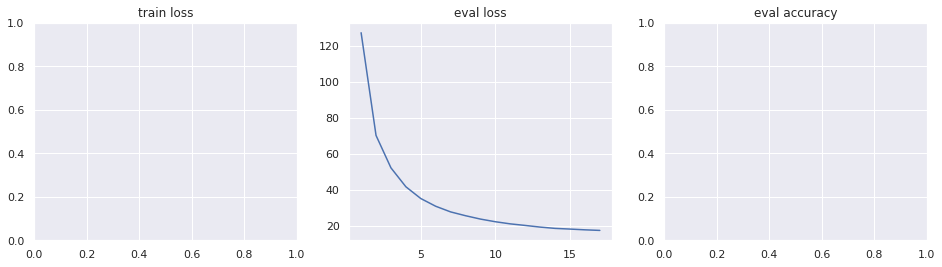

In [13]:
fig = plt.figure(figsize=(16, 4))
ax = plt.GridSpec(1, 3, figure=fig)

class_ax = plt.subplot(ax[0, 0])
contr_ax = plt.subplot(ax[0, 1])
test_ax = plt.subplot(ax[0, 2])

class_ax.set_title("train loss")
contr_ax.set_title("eval loss")
test_ax.set_title("eval accuracy") #classification loss on the test dataset

sns.lineplot(x=range(1, len(cb.train_loss) + 1), y=cb.train_loss, ax=contr_ax)
sns.lineplot(x=range(1, len(cb.eval_loss) + 1), y=cb.eval_loss, ax=class_ax)
sns.lineplot(x=range(1, len(cb.top1) + 1), y=cb.top1, ax=test_ax)

fig.show()